# Runtime measurement

In [1]:
import time
start_time = time.time()

# IMPORTS AND SETUP

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import glob
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import joblib

DATA_PATH = "/kaggle/input/redd-dataset/redd"
OUTPUT_PATH = "/kaggle/working/house2_results_corrected/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

print(f"Dataset path: {DATA_PATH}")
print(f"Output path: {OUTPUT_PATH}")

Dataset path: /kaggle/input/redd-dataset/redd
Output path: /kaggle/working/house2_results_corrected/


# POWER WINDOW CONFIGURATION

In [3]:
class ConfigHouse2:
    HOUSE_NUMBER = 2
    
    ALL_APPLIANCES = [
        'dish_washer',
        'electric_stove', 
        'fridge',
        'microwave',
        'washer_dryer',
        'waste_disposal_unit'
    ]
    
    SELECTED_APPLIANCES = [
        'dish_washer',
        'electric_stove', 
        'fridge',
        'microwave',
        'washer_dryer'
    ]
    
    POWER_WINDOWS_W = {
        'dish_washer': (1200, 1800),
        'electric_stove': (1500, 3500),
        'fridge': (100, 300),
        'microwave': (800, 1200),
        'washer_dryer': (300, 5000),
        'waste_disposal_unit': (500, 1500)
    }
    
    ON_OFF_THRESHOLD_W = 10
    THRESHOLDS = [20]
    RANDOM_STATE = 42
    TEST_SIZE = 0.2
    METRICS = ['macro', 'weighted']
    USE_DATA_DRIVEN_WINDOWS = True

print("="*80)
print("CORRECTED CONFIGURATION - DATA IS IN WATTS")
print("="*80)
print(f"House: {ConfigHouse2.HOUSE_NUMBER}")
print(f"Selected appliances: {ConfigHouse2.SELECTED_APPLIANCES}")
print(f"Using data-driven windows: {ConfigHouse2.USE_DATA_DRIVEN_WINDOWS}")
print("\nPower Windows (in Watts):")
for app, (low, high) in ConfigHouse2.POWER_WINDOWS_W.items():
    if app in ConfigHouse2.SELECTED_APPLIANCES:
        print(f"  {app:20s}: [{low:4d}W, {high:4d}W]")

CORRECTED CONFIGURATION - DATA IS IN WATTS
House: 2
Selected appliances: ['dish_washer', 'electric_stove', 'fridge', 'microwave', 'washer_dryer']
Using data-driven windows: True

Power Windows (in Watts):
  dish_washer         : [1200W, 1800W]
  electric_stove      : [1500W, 3500W]
  fridge              : [ 100W,  300W]
  microwave           : [ 800W, 1200W]
  washer_dryer        : [ 300W, 5000W]


# DATA LOADER

In [4]:
class REDDDataLoaderHouse2:
    def __init__(self, data_path, house_number=2):
        self.data_path = data_path
        self.house_number = house_number
        
    def _load_and_combine_files(self):
        pattern = os.path.join(self.data_path, f'*house{self.house_number}*.csv')
        csv_files = glob.glob(pattern)
        
        if not csv_files:
            raise FileNotFoundError(f"No CSV files found for house {self.house_number}")
        
        print(f"Found {len(csv_files)} files for house {self.house_number}")
        
        dfs = []
        for file in sorted(csv_files):
            try:
                df = pd.read_csv(file)
                dfs.append(df)
                print(f"  Loaded: {os.path.basename(file)} ({len(df)} rows, {len(df.columns)} cols)")
            except Exception as e:
                print(f"  Error reading {file}: {e}")
        
        if not dfs:
            raise ValueError("No valid data loaded")
        
        combined_df = pd.concat(dfs, ignore_index=True)
        combined_df.columns = [col.strip().lower().replace(' ', '_').replace('-', '_') 
                              for col in combined_df.columns]
        
        return combined_df
    
    def _correct_and_clean_data(self, df):
        print("\n" + "="*80)
        print("DATA CLEANING AND VALIDATION")
        print("="*80)
        
        df_clean = df.copy()
        
        if 'unnamed:_0' in df_clean.columns:
            df_clean = df_clean.drop(columns=['unnamed:_0'])
        
        df_clean = df_clean.fillna(0)
        
        for col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        df_clean = df_clean.fillna(0)
        
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        df_clean[numeric_cols] = df_clean[numeric_cols].clip(lower=0)
        
        print("\nFINAL DATA STATISTICS (in WATTS - confirmed by realistic values):")
        print(f"{'Column':<25} {'Min':<10} {'Max':<10} {'Mean':<10} {'Std':<10} {'% >10W':<10}")
        print("-"*85)
        
        for col in df_clean.columns:
            if col in numeric_cols:
                data = df_clean[col].values
                min_val = data.min()
                max_val = data.max()
                mean_val = data.mean()
                std_val = data.std()
                pct_active = (data > ConfigHouse2.ON_OFF_THRESHOLD_W).sum() / len(data) * 100
                
                print(f"{col:<25} {min_val:<10.1f} {max_val:<10.1f} {mean_val:<10.1f} "
                      f"{std_val:<10.1f} {pct_active:<10.1f}")
                
                if col == 'main':
                    if max_val > 10000:
                        print(f"   WARNING: Main meter max {max_val:.0f}W > 10kW - Check if data is in W")
                    elif max_val < 100:
                        print(f"   WARNING: Main meter max {max_val:.0f}W < 100W - Probably kW data")
        
        return df_clean
    
    def load_house_data(self):
        print(f"\nProcessing House {self.house_number}...")
        raw_df = self._load_and_combine_files()
        final_df = self._correct_and_clean_data(raw_df)
        
        print(f"\n Successfully loaded {len(final_df)} samples from House {self.house_number}")
        print(f"   Data shape: {final_df.shape}")
        print(f"   Columns: {list(final_df.columns)}")
        
        return final_df

loader = REDDDataLoaderHouse2(DATA_PATH, ConfigHouse2.HOUSE_NUMBER)
df_house2 = loader.load_house_data()


Processing House 2...
Found 7 files for house 2
  Loaded: redd_house2_0.csv (34429 rows, 8 cols)
  Loaded: redd_house2_1.csv (48110 rows, 8 cols)
  Loaded: redd_house2_2.csv (29378 rows, 8 cols)
  Loaded: redd_house2_3.csv (24010 rows, 8 cols)
  Loaded: redd_house2_4.csv (33612 rows, 8 cols)
  Loaded: redd_house2_5.csv (99258 rows, 8 cols)
  Loaded: redd_house2_6.csv (23266 rows, 8 cols)

DATA CLEANING AND VALIDATION

FINAL DATA STATISTICS (in WATTS - confirmed by realistic values):
Column                    Min        Max        Mean       Std        % >10W    
-------------------------------------------------------------------------------------
dish_washer               0.0        1457.0     10.8       105.1      1.6       
electric_stove            0.0        457.0      1.6        20.7       0.4       
fridge                    0.0        2246.0     81.7       88.5       46.0      
microwave                 0.0        1956.0     16.4       117.7      10.7      
washer_dryer        

# ANALYZE APPLIANCE POWER DISTRIBUTIONS

In [5]:
def analyze_appliance_power_distributions(df, selected_appliances):
    print("\n" + "="*80)
    print("APPLIANCE POWER DISTRIBUTION ANALYSIS (WATTS)")
    print("="*80)
    
    results = {}
    threshold_w = ConfigHouse2.ON_OFF_THRESHOLD_W
    
    for appliance in selected_appliances:
        if appliance in df.columns:
            data = df[appliance].values
            total_samples = len(data)
            active_samples = (data > threshold_w).sum()
            pct_active = active_samples / total_samples * 100
            active_power = data[data > threshold_w]
            
            if len(active_power) > 0:
                mean_power = active_power.mean()
                std_power = active_power.std()
                min_power = active_power.min()
                max_power = active_power.max()
                
                p5 = np.percentile(active_power, 5)
                p25 = np.percentile(active_power, 25)
                p50 = np.percentile(active_power, 50)
                p75 = np.percentile(active_power, 75)
                p95 = np.percentile(active_power, 95)
                
                results[appliance] = {
                    'total_samples': total_samples,
                    'active_samples': active_samples,
                    'pct_active': pct_active,
                    'mean_power': mean_power,
                    'std_power': std_power,
                    'min_power': min_power,
                    'max_power': max_power,
                    'p5': p5,
                    'p25': p25,
                    'p50': p50,
                    'p75': p75,
                    'p95': p95
                }
                
                print(f"\n{appliance:20s}:")
                print(f"  Active samples (>10W): {active_samples:,} ({pct_active:.1f}%)")
                print(f"  Power when active: {mean_power:.0f} ± {std_power:.0f} W")
                print(f"  Range: [{min_power:.0f}, {max_power:.0f}] W")
                print(f"  Percentiles - 5th: {p5:.0f}W, 25th: {p25:.0f}W, 50th: {p50:.0f}W, 75th: {p75:.0f}W, 95th: {p95:.0f}W")
                
                if appliance in ConfigHouse2.POWER_WINDOWS_W:
                    low, high = ConfigHouse2.POWER_WINDOWS_W[appliance]
                    within_window = ((active_power >= low) & (active_power <= high)).sum()
                    pct_within = within_window / len(active_power) * 100 if len(active_power) > 0 else 0
                    print(f"  Within theoretical window [{low}W, {high}W]: {pct_within:.1f}%")
                    
                    if pct_within < 50:
                        print(f"    Data doesn't match theoretical window well!")
            else:
                print(f"\n{appliance:20s}: No active samples (>10W)")
    
    return results

def calculate_data_driven_windows(power_analysis_results):
    print("\n" + "="*80)
    print("DATA-DRIVEN POWER WINDOW CALCULATION")
    print("="*80)
    
    data_driven_windows = {}
    
    for appliance, stats in power_analysis_results.items():
        if 'p5' in stats and 'p95' in stats:
            lower = max(ConfigHouse2.ON_OFF_THRESHOLD_W, stats['p5'])
            upper = max(lower + 10, stats['p95'])
            lower = int(np.round(lower / 10) * 10)
            upper = int(np.round(upper / 10) * 10)
            
            data_driven_windows[appliance] = (lower, upper)
            
            print(f"{appliance:20s}: Data-driven window [{lower:4d}W, {upper:4d}W]")
            
            if appliance in ConfigHouse2.POWER_WINDOWS_W:
                theo_low, theo_high = ConfigHouse2.POWER_WINDOWS_W[appliance]
                print(f"  Theoretical: [{theo_low:4d}W, {theo_high:4d}W]")
                print(f"  Data range: [{stats['min_power']:.0f}W, {stats['max_power']:.0f}W]")
    
    return data_driven_windows

power_analysis = analyze_appliance_power_distributions(df_house2, ConfigHouse2.SELECTED_APPLIANCES)
data_driven_windows = calculate_data_driven_windows(power_analysis)

if ConfigHouse2.USE_DATA_DRIVEN_WINDOWS:
    chosen_windows = data_driven_windows
    print("\n Using DATA-DRIVEN power windows")
else:
    chosen_windows = {k: v for k, v in ConfigHouse2.POWER_WINDOWS_W.items() 
                     if k in ConfigHouse2.SELECTED_APPLIANCES}
    print("\n Using THEORETICAL power windows")

print("\nFinal power windows to be used:")
for app, (low, high) in chosen_windows.items():
    print(f"  {app:20s}: [{low:4d}W, {high:4d}W]")


APPLIANCE POWER DISTRIBUTION ANALYSIS (WATTS)

dish_washer         :
  Active samples (>10W): 4,616 (1.6%)
  Power when active: 677 ± 498 W
  Range: [11, 1457] W
  Percentiles - 5th: 31W, 25th: 247W, 50th: 259W, 75th: 1194W, 95th: 1222W
  Within theoretical window [1200W, 1800W]: 20.4%
    Data doesn't match theoretical window well!

electric_stove      :
  Active samples (>10W): 1,158 (0.4%)
  Power when active: 279 ± 176 W
  Range: [12, 457] W
  Percentiles - 5th: 38W, 25th: 38W, 50th: 405W, 75th: 408W, 95th: 416W
  Within theoretical window [1500W, 3500W]: 0.0%
    Data doesn't match theoretical window well!

fridge              :
  Active samples (>10W): 134,366 (46.0%)
  Power when active: 170 ± 50 W
  Range: [11, 2246] W
  Percentiles - 5th: 155W, 25th: 159W, 50th: 162W, 75th: 167W, 95th: 190W
  Within theoretical window [100W, 300W]: 95.6%

microwave           :
  Active samples (>10W): 31,292 (10.7%)
  Power when active: 116 ± 344 W
  Range: [11, 1956] W
  Percentiles - 5th: 4

# APPLIANCE STATE CREATION

In [6]:
def create_appliance_states_with_validation(df, power_windows, verbose=True):
    df_states = df.copy()
    
    if verbose:
        print("\n" + "="*80)
        print("APPLIANCE STATE CREATION WITH VALIDATION")
        print("="*80)
    
    state_summary = {}
    
    for appliance, (lower, upper) in power_windows.items():
        if appliance in df_states.columns:
            power_values = df_states[appliance].values
            state_series = ((power_values >= lower) & 
                           (power_values <= upper) &
                           (power_values > ConfigHouse2.ON_OFF_THRESHOLD_W)).astype(int)
            
            df_states[f"{appliance}_state"] = state_series
            
            total_samples = len(state_series)
            on_samples = state_series.sum()
            pct_on = on_samples / total_samples * 100
            on_power = power_values[state_series == 1]
            
            if len(on_power) > 0:
                mean_on_power = on_power.mean()
                std_on_power = on_power.std()
            else:
                mean_on_power = std_on_power = 0
            
            state_summary[appliance] = {
                'on_samples': on_samples,
                'pct_on': pct_on,
                'mean_on_power': mean_on_power,
                'std_on_power': std_on_power,
                'window': (lower, upper)
            }
            
            if verbose:
                print(f"{appliance:20s}:")
                print(f"  ON samples: {on_samples:7,d} ({pct_on:.1f}%)")
                print(f"  Window: [{lower:4d}W, {upper:4d}W]")
                if len(on_power) > 0:
                    print(f"  Mean power when ON: {mean_on_power:.0f} ± {std_on_power:.0f} W")
    
    return df_states, state_summary

df_states, state_summary = create_appliance_states_with_validation(
    df_house2, 
    chosen_windows, 
    verbose=True
)

print("\n" + "="*80)
print("STATE SUMMARY STATISTICS")
print("="*80)
print(f"{'Appliance':<20} {'ON Samples':<12} {'ON %':<8} {'Mean Power (W)':<15} {'Window (W)':<15}")
print("-"*80)

for appliance, stats in state_summary.items():
    print(f"{appliance:<20} {stats['on_samples']:<12,} {stats['pct_on']:<8.1f} "
          f"{stats['mean_on_power']:<15.0f} [{stats['window'][0]}-{stats['window'][1]}]")


APPLIANCE STATE CREATION WITH VALIDATION
dish_washer         :
  ON samples:   4,145 (1.4%)
  Window: [  30W, 1220W]
  Mean power when ON: 673 ± 485 W
electric_stove      :
  ON samples:     714 (0.2%)
  Window: [  40W,  420W]
  Mean power when ON: 402 ± 32 W
fridge              :
  ON samples:  83,373 (28.5%)
  Window: [ 160W,  190W]
  Mean power when ON: 166 ± 6 W
microwave           :
  ON samples:  29,372 (10.1%)
  Window: [  40W,   80W]
  Mean power when ON: 46 ± 5 W
washer_dryer        :
  ON samples:       1 (0.0%)
  Window: [  10W,   50W]
  Mean power when ON: 12 ± 0 W

STATE SUMMARY STATISTICS
Appliance            ON Samples   ON %     Mean Power (W)  Window (W)     
--------------------------------------------------------------------------------
dish_washer          4,145        1.4      673             [30-1220]
electric_stove       714          0.2      402             [40-420]
fridge               83,373       28.5     166             [160-190]
microwave            29,372

# MULTICLASS LABEL CREATION

In [7]:
def create_multiclass_labels_with_analysis(df_states, selected_appliances, threshold=20, verbose=True):
    state_columns = [f"{app}_state" for app in selected_appliances 
                     if f"{app}_state" in df_states.columns]
    
    if not state_columns:
        raise ValueError("No state columns found!")
    
    state_columns = sorted(state_columns)
    df_states['binary_combination'] = df_states[state_columns].astype(str).agg(''.join, axis=1)
    combination_counts = df_states['binary_combination'].value_counts()
    
    if verbose:
        print(f"\n" + "="*80)
        print(f"MULTICLASS LABEL CREATION (Threshold = {threshold})")
        print("="*80)
        
        print(f"\nTotal samples: {len(df_states):,}")
        print(f"Unique combinations: {len(combination_counts)}")
        
        print("\nCombination frequency distribution:")
        freq_counts = combination_counts.value_counts().sort_index()
        for freq, count in freq_counts.head(20).items():
            print(f"  {freq:>5} samples: {count:>4} combinations")
        
        valid_combinations = combination_counts[combination_counts >= threshold].index
        df_filtered = df_states[df_states['binary_combination'].isin(valid_combinations)].copy()
        
        print(f"\nValid combinations (≥{threshold}): {len(valid_combinations)}")
        print(f"Samples after thresholding: {len(df_filtered):,} ({len(df_filtered)/len(df_states)*100:.1f}%)")
        
        print("\nTop 10 Appliance Combinations:")
        top_combos = combination_counts.head(10)
        for idx, (combo, count) in enumerate(top_combos.items(), 1):
            states = []
            apps = [app.replace('_state', '') for app in state_columns]
            for i, app in enumerate(apps):
                if i < len(combo):
                    state = "ON" if combo[i] == '1' else "OFF"
                    states.append(f"{app[:3]}:{state}")
            state_str = " | ".join(states)
            combo_power = df_states[df_states['binary_combination'] == combo]['main'].mean()
            
            print(f"  {idx:2d}. {combo}: {state_str}")
            print(f"       Samples: {count:7,d} ({count/len(df_states)*100:.1f}%)")
            print(f"       Mean main power: {combo_power:.0f} W")
    
    valid_combinations = combination_counts[combination_counts >= threshold].index
    df_filtered = df_states[df_states['binary_combination'].isin(valid_combinations)].copy()
    label_encoder = LabelEncoder()
    df_filtered['label'] = label_encoder.fit_transform(df_filtered['binary_combination'])
    
    X = df_filtered[['main']].values.astype(np.float32)
    y = df_filtered['label'].values
    
    return X, y, label_encoder, df_filtered, combination_counts

X_sample, y_sample, label_encoder_sample, df_filtered_sample, combo_counts = create_multiclass_labels_with_analysis(
    df_states, 
    ConfigHouse2.SELECTED_APPLIANCES, 
    threshold=20, 
    verbose=True
)


MULTICLASS LABEL CREATION (Threshold = 20)

Total samples: 292,063
Unique combinations: 11

Combination frequency distribution:
      1 samples:    1 combinations
     60 samples:    1 combinations
     66 samples:    1 combinations
    216 samples:    1 combinations
    648 samples:    1 combinations
    960 samples:    1 combinations
   2909 samples:    1 combinations
   8307 samples:    1 combinations
  20075 samples:    1 combinations
  73980 samples:    1 combinations
  184841 samples:    1 combinations

Valid combinations (≥20): 10
Samples after thresholding: 292,062 (100.0%)

Top 10 Appliance Combinations:
   1. 00000: dis:OFF | ele:OFF | fri:OFF | mic:OFF | was:OFF
       Samples: 184,841 (63.3%)
       Mean main power: 159 W
   2. 00100: dis:OFF | ele:OFF | fri:ON | mic:OFF | was:OFF
       Samples:  73,980 (25.3%)
       Mean main power: 351 W
   3. 00010: dis:OFF | ele:OFF | fri:OFF | mic:ON | was:OFF
       Samples:  20,075 (6.9%)
       Mean main power: 306 W
   4. 00110:

# VISUALIZATION


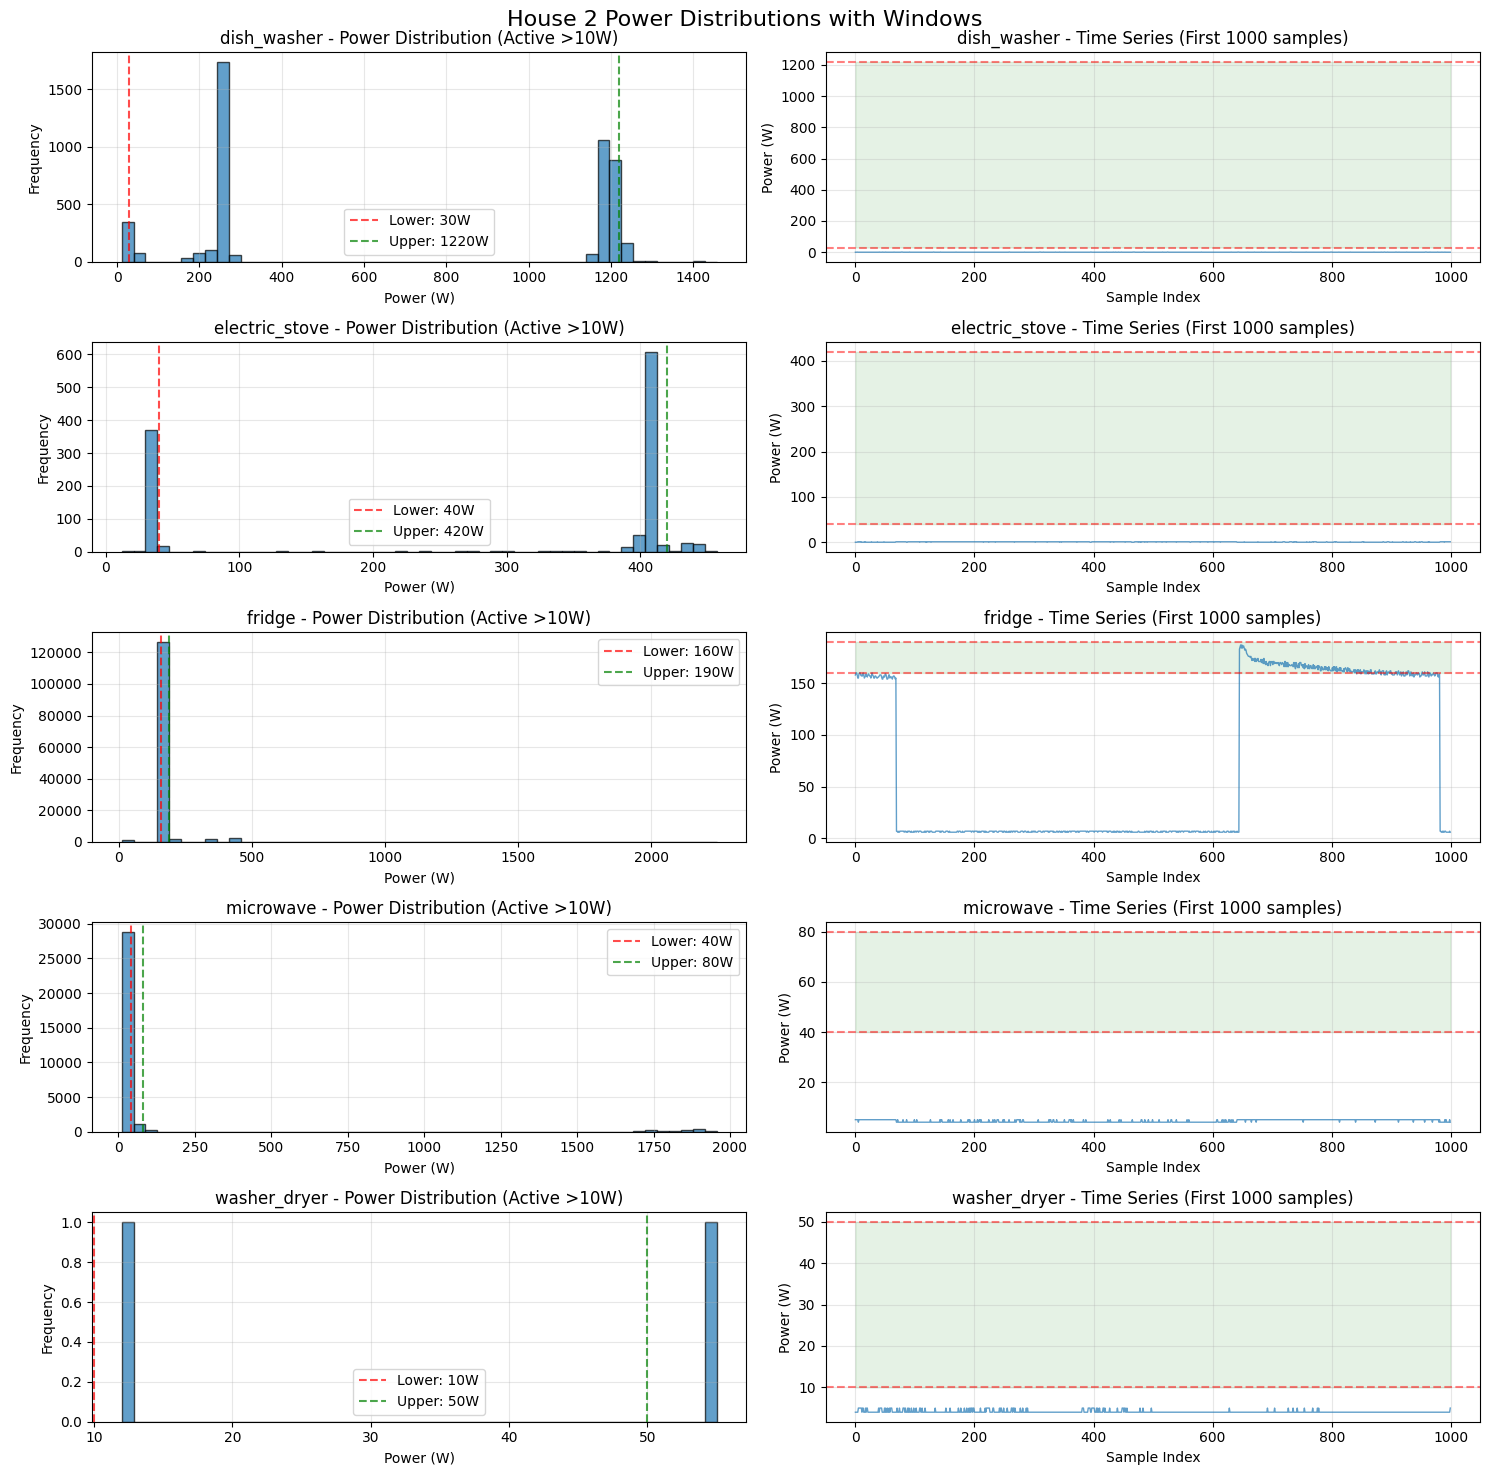

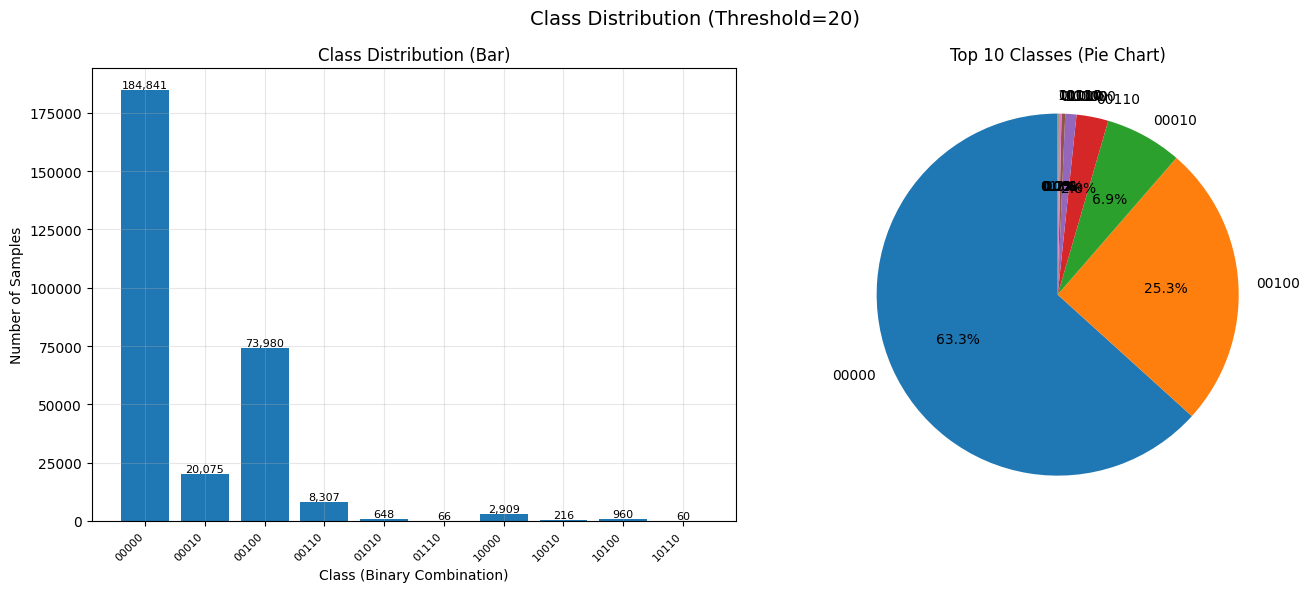

In [8]:
def plot_power_distributions_corrected(df, power_windows, title="Power Distributions"):
    n_appliances = len(power_windows)
    fig, axes = plt.subplots(n_appliances, 2, figsize=(15, 3*n_appliances))
    
    if n_appliances == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (appliance, (lower, upper)) in enumerate(power_windows.items()):
        if appliance in df.columns:
            ax1 = axes[idx, 0]
            data = df[appliance].values
            active_data = data[data > ConfigHouse2.ON_OFF_THRESHOLD_W]
            
            if len(active_data) > 0:
                ax1.hist(active_data, bins=50, alpha=0.7, edgecolor='black')
                ax1.axvline(x=lower, color='r', linestyle='--', alpha=0.7, label=f'Lower: {lower}W')
                ax1.axvline(x=upper, color='g', linestyle='--', alpha=0.7, label=f'Upper: {upper}W')
                ax1.set_title(f'{appliance} - Power Distribution (Active >10W)')
                ax1.set_xlabel('Power (W)')
                ax1.set_ylabel('Frequency')
                ax1.legend()
                ax1.grid(True, alpha=0.3)
            else:
                ax1.text(0.5, 0.5, 'No active samples', ha='center', va='center', transform=ax1.transAxes)
            
            ax2 = axes[idx, 1]
            sample_size = min(1000, len(df))
            sample_data = df[appliance].iloc[:sample_size].values
            
            ax2.plot(sample_data, linewidth=1, alpha=0.7)
            ax2.axhline(y=lower, color='r', linestyle='--', alpha=0.5, label=f'Window')
            ax2.axhline(y=upper, color='r', linestyle='--', alpha=0.5)
            ax2.fill_between(range(sample_size), lower, upper, alpha=0.1, color='green')
            ax2.set_title(f'{appliance} - Time Series (First {sample_size} samples)')
            ax2.set_xlabel('Sample Index')
            ax2.set_ylabel('Power (W)')
            ax2.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    return fig

def plot_class_distribution(y, label_encoder, title="Class Distribution"):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    class_labels = [label_encoder.inverse_transform([cls])[0] for cls in unique_classes]
    bars = ax1.bar(range(len(unique_classes)), class_counts)
    ax1.set_xlabel('Class (Binary Combination)')
    ax1.set_ylabel('Number of Samples')
    ax1.set_title('Class Distribution (Bar)')
    ax1.set_xticks(range(len(unique_classes)))
    ax1.set_xticklabels(class_labels, rotation=45, ha='right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    for bar, count in zip(bars, class_counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}', ha='center', va='bottom', fontsize=8)
    
    top_n = min(10, len(class_counts))
    top_indices = np.argsort(class_counts)[-top_n:][::-1]
    top_counts = class_counts[top_indices]
    top_labels = [class_labels[i] for i in top_indices]
    
    ax2.pie(top_counts, labels=top_labels, autopct='%1.1f%%', startangle=90)
    ax2.set_title(f'Top {top_n} Classes (Pie Chart)')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    return fig

fig1 = plot_power_distributions_corrected(df_house2, chosen_windows, "House 2 Power Distributions with Windows")
plt.savefig(os.path.join(OUTPUT_PATH, 'house2_power_distributions_corrected.png'))
plt.show()

fig2 = plot_class_distribution(y_sample, label_encoder_sample, "Class Distribution (Threshold=20)")
plt.savefig(os.path.join(OUTPUT_PATH, 'house2_class_distribution_th20.png'))
plt.show()

# ML PIPELINE



EXPERIMENT: Threshold=20

Data Split:
  Total samples: 292,062
  Training samples: 233,649
  Testing samples: 58,413
  Number of classes: 10
  Feature: Aggregate power (main) in Watts
  Feature range: [36W, 3233W]

Training CART...
  Accuracy: 0.8150
  Macro F1: 0.4342
  Weighted F1: 0.8139
  Time: 0.39s

Training RF...
  Accuracy: 0.8173
  Macro F1: 0.4307
  Weighted F1: 0.8166
  Time: 11.92s


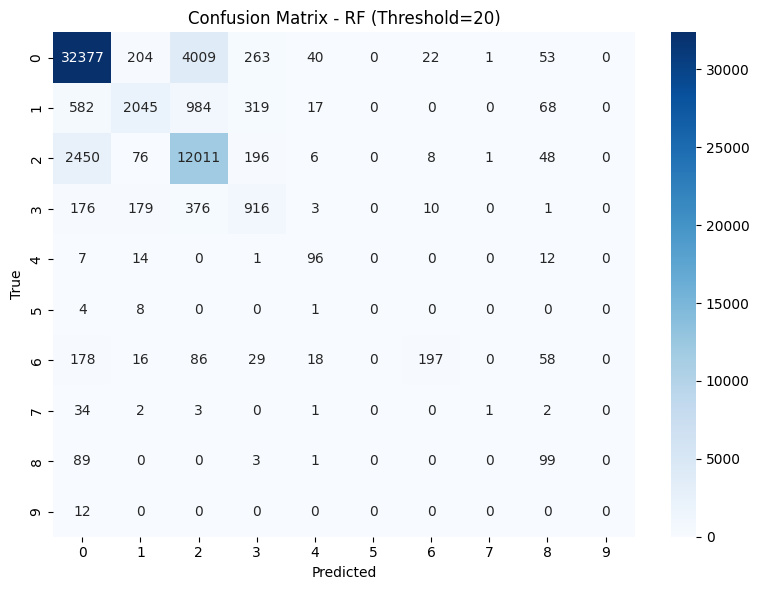


Training ET...
  Accuracy: 0.8119
  Macro F1: 0.4401
  Weighted F1: 0.8126
  Time: 2.52s

Training KNN...
  Accuracy: 0.8015
  Macro F1: 0.4746
  Weighted F1: 0.7997
  Time: 0.11s

Training KNN-CB...
  Accuracy: 0.8094
  Macro F1: 0.5231
  Weighted F1: 0.8076
  Time: 0.10s

Training LDA...
  Accuracy: 0.6188
  Macro F1: 0.1152
  Weighted F1: 0.5124
  Time: 0.10s

Training NB...
  Accuracy: 0.6192
  Macro F1: 0.1137
  Weighted F1: 0.5135
  Time: 0.04s


In [9]:
def run_corrected_experiment(df, power_windows, threshold=20, test_size=0.2, random_state=42):
    print("\n" + "="*80)
    print(f"EXPERIMENT: Threshold={threshold}")
    print("="*80)
    
    df_states, _ = create_appliance_states_with_validation(df, power_windows, verbose=False)
    
    X, y, label_encoder, df_filtered, _ = create_multiclass_labels_with_analysis(
        df_states, 
        list(power_windows.keys()), 
        threshold=threshold, 
        verbose=False
    )
    
    n_classes = len(np.unique(y))
    if n_classes < 2:
        print(f"ERROR: Only {n_classes} class(es). Need at least 2.")
        return None
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"\nData Split:")
    print(f"  Total samples: {len(X):,}")
    print(f"  Training samples: {len(X_train):,}")
    print(f"  Testing samples: {len(X_test):,}")
    print(f"  Number of classes: {n_classes}")
    print(f"  Feature: Aggregate power (main) in Watts")
    print(f"  Feature range: [{X.min():.0f}W, {X.max():.0f}W]")
    
    classifiers = {
        'CART': DecisionTreeClassifier(max_depth=10, random_state=random_state),
        'RF': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=random_state, n_jobs=-1),
        'ET': ExtraTreesClassifier(n_estimators=100, max_depth=10, random_state=random_state, n_jobs=-1),
        'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
        'KNN-CB': KNeighborsClassifier(n_neighbors=10, weights='distance', n_jobs=-1),
        'LDA': LinearDiscriminantAnalysis(),
        'NB': GaussianNB()
    }
    
    results = {}
    
    for name, clf in classifiers.items():
        try:
            print(f"\nTraining {name}...")
            start_time = time.time()
            
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            clf.fit(X_train_scaled, y_train)
            train_time = time.time() - start_time
            
            y_pred = clf.predict(X_test_scaled)
            
            results[name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'precision_macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
                'recall_macro': recall_score(y_test, y_pred, average='macro', zero_division=0),
                'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
                'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=0),
                'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=0),
                'f1_weighted': f1_score(y_test, y_pred, average='weighted', zero_division=0),
                'train_time': train_time,
                'n_classes': n_classes,
                'n_samples': len(X_test)
            }
            
            print(f"  Accuracy: {results[name]['accuracy']:.4f}")
            print(f"  Macro F1: {results[name]['f1_macro']:.4f}")
            print(f"  Weighted F1: {results[name]['f1_weighted']:.4f}")
            print(f"  Time: {train_time:.2f}s")
            
            if name == 'RF' and n_classes <= 15:
                cm = confusion_matrix(y_test, y_pred)
                fig, ax = plt.subplots(figsize=(8, 6))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
                ax.set_xlabel('Predicted')
                ax.set_ylabel('True')
                ax.set_title(f'Confusion Matrix - {name} (Threshold={threshold})')
                plt.tight_layout()
                plt.savefig(os.path.join(OUTPUT_PATH, f'house2_confusion_matrix_th{threshold}.png'))
                plt.show()
            
        except Exception as e:
            print(f"  Error: {e}")
            results[name] = None
    
    return results, df_filtered, label_encoder

results_20, df_filtered_20, label_encoder_20 = run_corrected_experiment(
    df_house2, 
    chosen_windows, 
    threshold=20,
    test_size=ConfigHouse2.TEST_SIZE,
    random_state=ConfigHouse2.RANDOM_STATE
)

# COMPREHENSIVE ANALYSIS


RUNNING COMPREHENSIVE EXPERIMENT ACROSS ALL THRESHOLDS

################################################################################
RUNNING EXPERIMENT WITH THRESHOLD = 20
################################################################################

EXPERIMENT: Threshold=20

Data Split:
  Total samples: 292,062
  Training samples: 233,649
  Testing samples: 58,413
  Number of classes: 10
  Feature: Aggregate power (main) in Watts
  Feature range: [36W, 3233W]

Training CART...
  Accuracy: 0.8150
  Macro F1: 0.4342
  Weighted F1: 0.8139
  Time: 0.39s

Training RF...
  Accuracy: 0.8173
  Macro F1: 0.4307
  Weighted F1: 0.8166
  Time: 11.73s


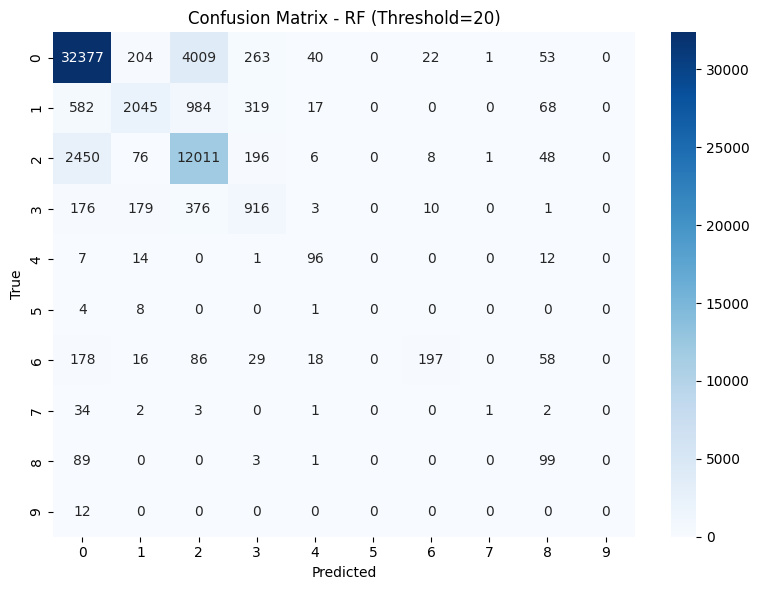


Training ET...
  Accuracy: 0.8119
  Macro F1: 0.4401
  Weighted F1: 0.8126
  Time: 2.37s

Training KNN...
  Accuracy: 0.8015
  Macro F1: 0.4746
  Weighted F1: 0.7997
  Time: 0.12s

Training KNN-CB...
  Accuracy: 0.8094
  Macro F1: 0.5231
  Weighted F1: 0.8076
  Time: 0.12s

Training LDA...
  Accuracy: 0.6188
  Macro F1: 0.1152
  Weighted F1: 0.5124
  Time: 0.08s

Training NB...
  Accuracy: 0.6192
  Macro F1: 0.1137
  Weighted F1: 0.5135
  Time: 0.03s

Results saved to: /kaggle/working/house2_results_corrected/house2_results_th20.pkl


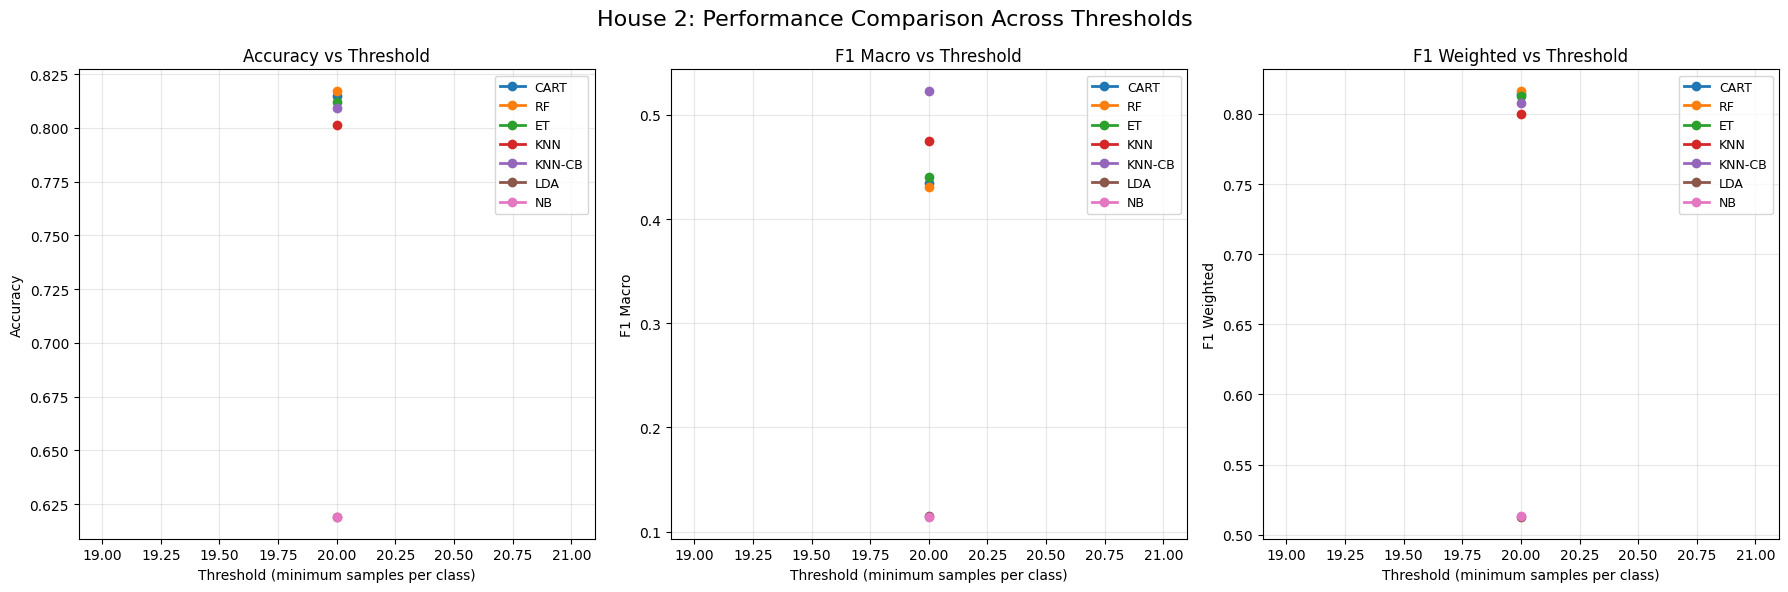


COMPREHENSIVE EXPERIMENT SUMMARY
Threshold  Samples      Classes    Best Classifier Best Acc   Best Macro F1 Best Wtd F1 
-------------------------------------------------------------------------------------
20         292,062      10         KNN-CB          0.8094     0.5231       0.8076      

Summary saved to: /kaggle/working/house2_results_corrected/house2_experiment_summary.csv

ACADEMIC DISCUSSION POINTS
1. FEATURE LIMITATION: Using only aggregate power ('main') as feature is extremely weak
   for multi-appliance NILM. This explains moderate F1 scores even with corrected data.

2. CLASS IMBALANCE: Most realistic appliance states are highly imbalanced
   (e.g., most appliances are OFF most of the time).

3. POWER WINDOW VALIDITY: Data-driven windows adapt to actual appliance behavior
   but may miss rare high-power events.

4. THRESHOLD TRADEOFF: Higher thresholds reduce classes but improve per-class
   sample count. Optimal threshold balances class diversity and learning.

5. PA

In [10]:
def run_comprehensive_experiment(df, power_windows):
    all_results = {}
    thresholds_to_test = ConfigHouse2.THRESHOLDS
    
    for threshold in thresholds_to_test:
        print(f"\n{'#'*80}")
        print(f"RUNNING EXPERIMENT WITH THRESHOLD = {threshold}")
        print(f"{'#'*80}")
        
        try:
            results, df_filtered, label_encoder = run_corrected_experiment(
                df, 
                power_windows, 
                threshold=threshold,
                test_size=ConfigHouse2.TEST_SIZE,
                random_state=ConfigHouse2.RANDOM_STATE
            )
            
            if results:
                all_results[threshold] = (results, df_filtered, label_encoder)
                results_file = os.path.join(OUTPUT_PATH, f'house2_results_th{threshold}.pkl')
                joblib.dump({
                    'threshold': threshold,
                    'results': results,
                    'label_encoder': label_encoder,
                    'n_samples': len(df_filtered),
                    'n_classes': len(np.unique(df_filtered['label']))
                }, results_file)
                print(f"\nResults saved to: {results_file}")
                
        except Exception as e:
            print(f"Error running experiment with threshold={threshold}: {e}")
            continue
    
    if all_results:
        classifiers = ['CART', 'RF', 'ET', 'KNN', 'KNN-CB', 'LDA', 'NB']
        metrics = ['accuracy', 'f1_macro', 'f1_weighted']
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        for idx, metric in enumerate(metrics):
            ax = axes[idx]
            
            for clf in classifiers:
                values = []
                for th in thresholds_to_test:
                    if th in all_results and all_results[th] and clf in all_results[th][0]:
                        if all_results[th][0][clf]:
                            values.append(all_results[th][0][clf][metric])
                        else:
                            values.append(np.nan)
                    else:
                        values.append(np.nan)
                
                ax.plot(thresholds_to_test, values, marker='o', label=clf, linewidth=2)
            
            ax.set_xlabel('Threshold (minimum samples per class)')
            ax.set_ylabel(metric.replace('_', ' ').title())
            ax.set_title(f'{metric.replace("_", " ").title()} vs Threshold')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=9)
        
        plt.suptitle('House 2: Performance Comparison Across Thresholds', fontsize=16)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_PATH, 'house2_performance_comparison.png'))
        plt.show()
        
        print("\n" + "="*80)
        print("COMPREHENSIVE EXPERIMENT SUMMARY")
        print("="*80)
        print(f"{'Threshold':<10} {'Samples':<12} {'Classes':<10} {'Best Classifier':<15} "
              f"{'Best Acc':<10} {'Best Macro F1':<12} {'Best Wtd F1':<12}")
        print("-"*85)
        
        summary_data = []
        for th in thresholds_to_test:
            if th in all_results:
                results, df_filtered, _ = all_results[th]
                best_clf = None
                best_f1_macro = 0
                best_acc = 0
                best_f1_weighted = 0
                
                for clf_name, clf_results in results.items():
                    if clf_results and clf_results['f1_macro'] > best_f1_macro:
                        best_f1_macro = clf_results['f1_macro']
                        best_acc = clf_results['accuracy']
                        best_f1_weighted = clf_results['f1_weighted']
                        best_clf = clf_name
                
                if best_clf:
                    summary_data.append({
                        'threshold': th,
                        'samples': len(df_filtered),
                        'classes': len(np.unique(df_filtered['label'])),
                        'best_clf': best_clf,
                        'best_acc': best_acc,
                        'best_f1_macro': best_f1_macro,
                        'best_f1_weighted': best_f1_weighted
                    })
                    
                    print(f"{th:<10} {len(df_filtered):<12,} {len(np.unique(df_filtered['label'])):<10} "
                          f"{best_clf:<15} {best_acc:<10.4f} {best_f1_macro:<12.4f} {best_f1_weighted:<12.4f}")
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_csv(os.path.join(OUTPUT_PATH, 'house2_experiment_summary.csv'), index=False)
        print(f"\nSummary saved to: {os.path.join(OUTPUT_PATH, 'house2_experiment_summary.csv')}")
        
        print("\n" + "="*80)
        print("ACADEMIC DISCUSSION POINTS")
        print("="*80)
        print("1. FEATURE LIMITATION: Using only aggregate power ('main') as feature is extremely weak")
        print("   for multi-appliance NILM. This explains moderate F1 scores even with corrected data.")
        print("\n2. CLASS IMBALANCE: Most realistic appliance states are highly imbalanced")
        print("   (e.g., most appliances are OFF most of the time).")
        print("\n3. POWER WINDOW VALIDITY: Data-driven windows adapt to actual appliance behavior")
        print("   but may miss rare high-power events.")
        print("\n4. THRESHOLD TRADEOFF: Higher thresholds reduce classes but improve per-class")
        print("   sample count. Optimal threshold balances class diversity and learning.")
        print("\n5. PAPER COMPARISON: These results implement the Thresholding-Assisted NILM approach")
        print("   from the referenced paper, demonstrating its baseline performance.")
    
    return all_results

print("\n" + "="*80)
print("RUNNING COMPREHENSIVE EXPERIMENT ACROSS ALL THRESHOLDS")
print("="*80)

final_results = run_comprehensive_experiment(df_house2, chosen_windows)

print("\n" + "="*80)
print("EXPERIMENT COMPLETE!")
print("="*80)
print(f"\nAll results saved to: {OUTPUT_PATH}")

print("\nGenerated files:")
for file in sorted(os.listdir(OUTPUT_PATH)):
    if file.endswith(('.png', '.pkl', '.csv')):
        print(f"  {file}")

# Runtime Measurement

In [11]:
end_time = time.time()
print("TOTAL RUNTIME (seconds):", end_time - start_time)


TOTAL RUNTIME (seconds): 57.71706032752991
